In [1]:
#import neccessary libraries
import pandas as pd
import time
import threading
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt

In [7]:
# Load the dataset
df = pd.read_csv('Groceries_dataset.csv')
df

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


In [10]:
from mlxtend.preprocessing import TransactionEncoder


# Group the data by 'Member_number' (TransactionID) and aggregate items into lists
grouped_df = df.groupby('Member_number')['itemDescription'].apply(list).reset_index()

# Convert transactions to a list of lists
transactions = grouped_df['itemDescription'].tolist()

# Apply TransactionEncoder to one-hot encode the transaction data
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
onehot_df = pd.DataFrame(te_ary, columns=te.columns_)

In [12]:
onehot_df.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [14]:
# Set parameters
min_support = 0.01
metric = "lift"
min_threshold = 1.0

In [16]:
# Functions for running the algorithms
def run_apriori(df, min_support, metric, min_threshold):
    start_time = time.time()
    # Run Apriori algorithm
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)
    apriori_time = time.time() - start_time
    return rules, apriori_time

def run_fpgrowth(df, min_support, metric, min_threshold):
    start_time = time.time()
    # Run FP-Growth algorithm
    frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)
    fpgrowth_time = time.time() - start_time
    return rules, fpgrowth_time

In [20]:
# Prepare to store the execution times
apriori_time = None
fpgrowth_time = None
rules_fpgrowth = None
rules_apriori = None

# Run both algorithms concurrently and capture their execution times
def run_and_store_apriori(df, min_support, metric, min_threshold):
    global apriori_time
    global rules_apriori
    rules_apriori = apriori(df, min_support=min_support, use_colnames=True)
    _, apriori_time = run_apriori(df, min_support, metric, min_threshold)

def run_and_store_fpgrowth(df, min_support, metric, min_threshold):
    global fpgrowth_time
    global rules_fpgrowth
    rules_fpgrowth = fpgrowth(df, min_support=min_support, use_colnames=True)
    _, fpgrowth_time = run_fpgrowth(df, min_support, metric, min_threshold)

apriori_thread = threading.Thread(target=run_and_store_apriori, args=(onehot_df, min_support, metric, min_threshold))
fpgrowth_thread = threading.Thread(target=run_and_store_fpgrowth, args=(onehot_df, min_support, metric, min_threshold))

apriori_thread.start()
fpgrowth_thread.start()

apriori_thread.join()
fpgrowth_thread.join()



Text(0.5, 1.0, 'Execution Time Comparison: Apriori vs FP-Growth')

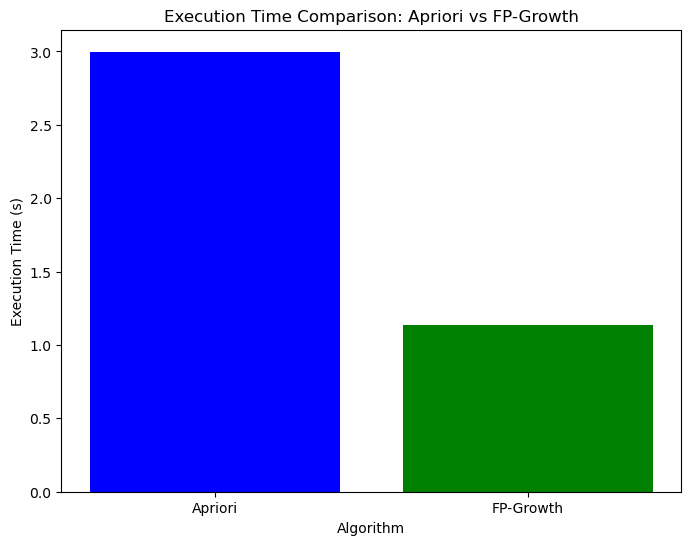

In [21]:
#Visualization of Execution Times
execution_times = {'Algorithm': ['Apriori', 'FP-Growth'], 'Execution Time (s)': [apriori_time, fpgrowth_time]}
execution_df = pd.DataFrame(execution_times)

plt.figure(figsize=(8, 6))
plt.bar(execution_df['Algorithm'], execution_df['Execution Time (s)'], color=['blue', 'green'])
plt.xlabel('Algorithm')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time Comparison: Apriori vs FP-Growth')

Text(0.5, 1.0, 'Number of Association Rules: Apriori vs FP-Growth')

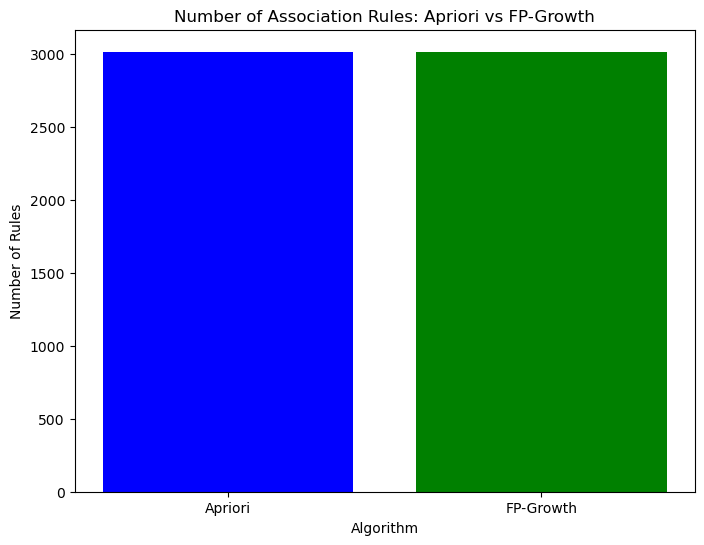

In [24]:
#Visualization of Results - Number of Rules
rules_count = {'Algorithm': ['Apriori', 'FP-Growth'], 'Number of Rules': [len(rules_apriori), len(rules_fpgrowth)]}
rules_df = pd.DataFrame(rules_count)

plt.figure(figsize=(8, 6))
plt.bar(rules_df['Algorithm'], rules_df['Number of Rules'], color=['blue', 'green'])
plt.xlabel('Algorithm')
plt.ylabel('Number of Rules')
plt.title('Number of Association Rules: Apriori vs FP-Growth')

Text(0.5, 1.0, 'Top 10 Frequent Itemsets - Apriori Algorithm')

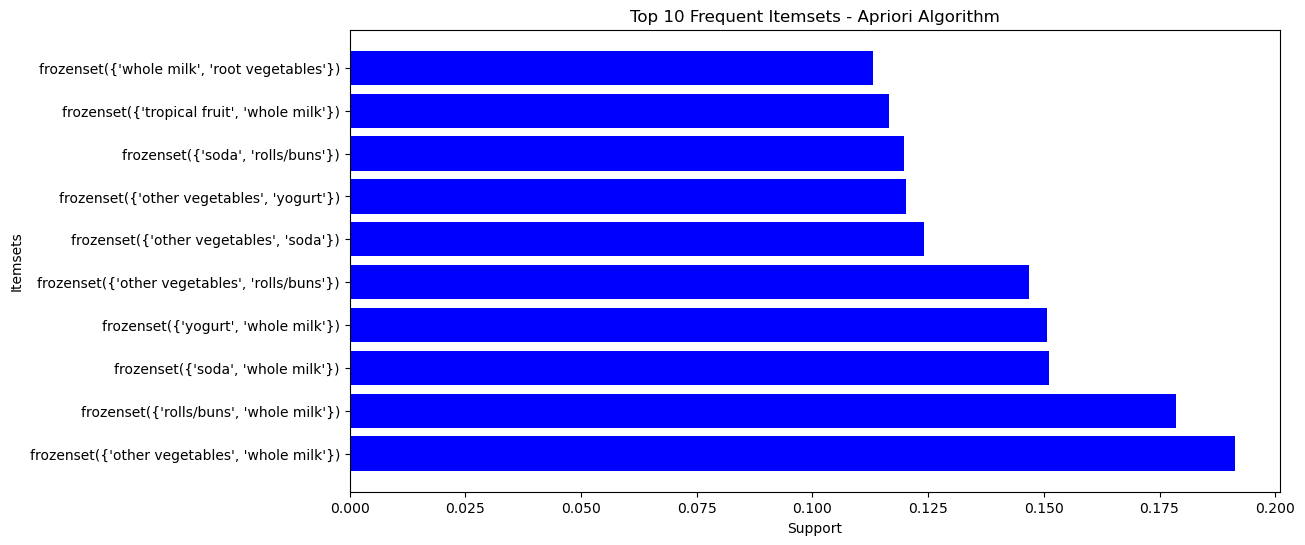

In [26]:
rules_apriori['length'] = rules_apriori['itemsets'].apply(lambda x: len(x))

# Filter itemsets with length greater than 1
apriori_results_filtered = rules_apriori[rules_apriori['length'] > 1]

# Sort by support
apriori_results_sorted = apriori_results_filtered.sort_values(by='support', ascending=False).head(10)

# Plot the top 10 itemsets
plt.figure(figsize=(12, 6))
plt.barh([str(item) for item in apriori_results_sorted['itemsets']], apriori_results_sorted['support'], color='blue')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 10 Frequent Itemsets - Apriori Algorithm')

Text(0.5, 1.0, 'Top 10 Frequent Itemsets - FP-Growth Algorithm')

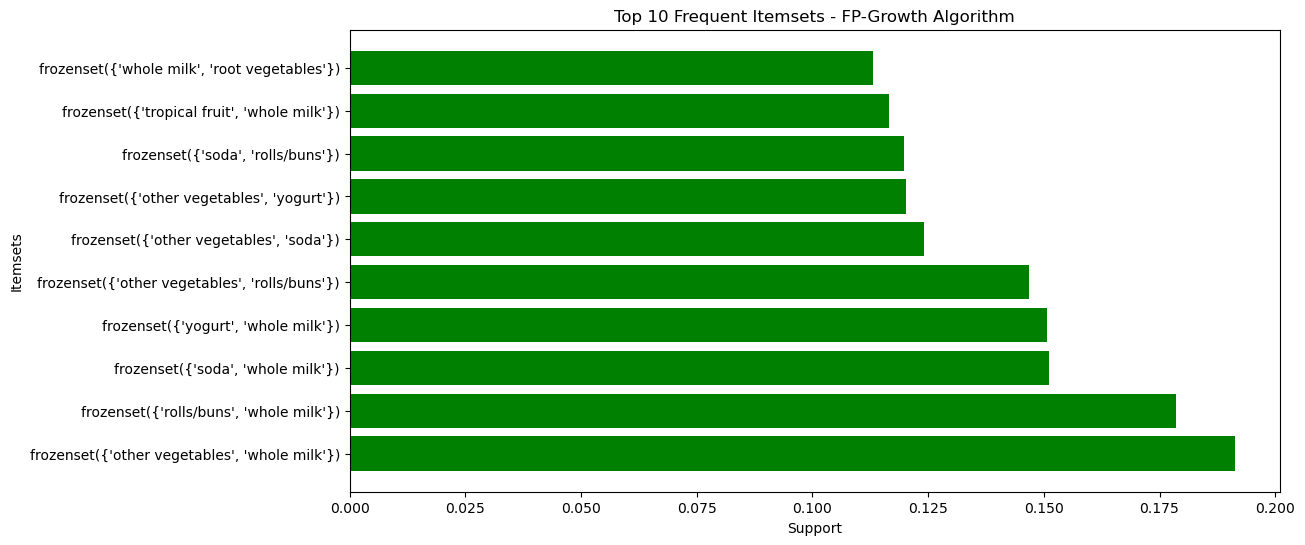

In [28]:
# Assuming fpgrowth_results is a DataFrame with columns 'itemsets' and 'support'
rules_fpgrowth['length'] = rules_fpgrowth['itemsets'].apply(lambda x: len(x))

# Filter itemsets with length greater than 1
fpgrowth_results_filtered = rules_fpgrowth[rules_fpgrowth['length'] > 1]

# Sort by support
fpgrowth_results_sorted = fpgrowth_results_filtered.sort_values(by='support', ascending=False).head(10)

# Plot the top 10 itemsets
plt.figure(figsize=(12, 6))
plt.barh([str(item) for item in fpgrowth_results_sorted['itemsets']], fpgrowth_results_sorted['support'], color='green')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 10 Frequent Itemsets - FP-Growth Algorithm')

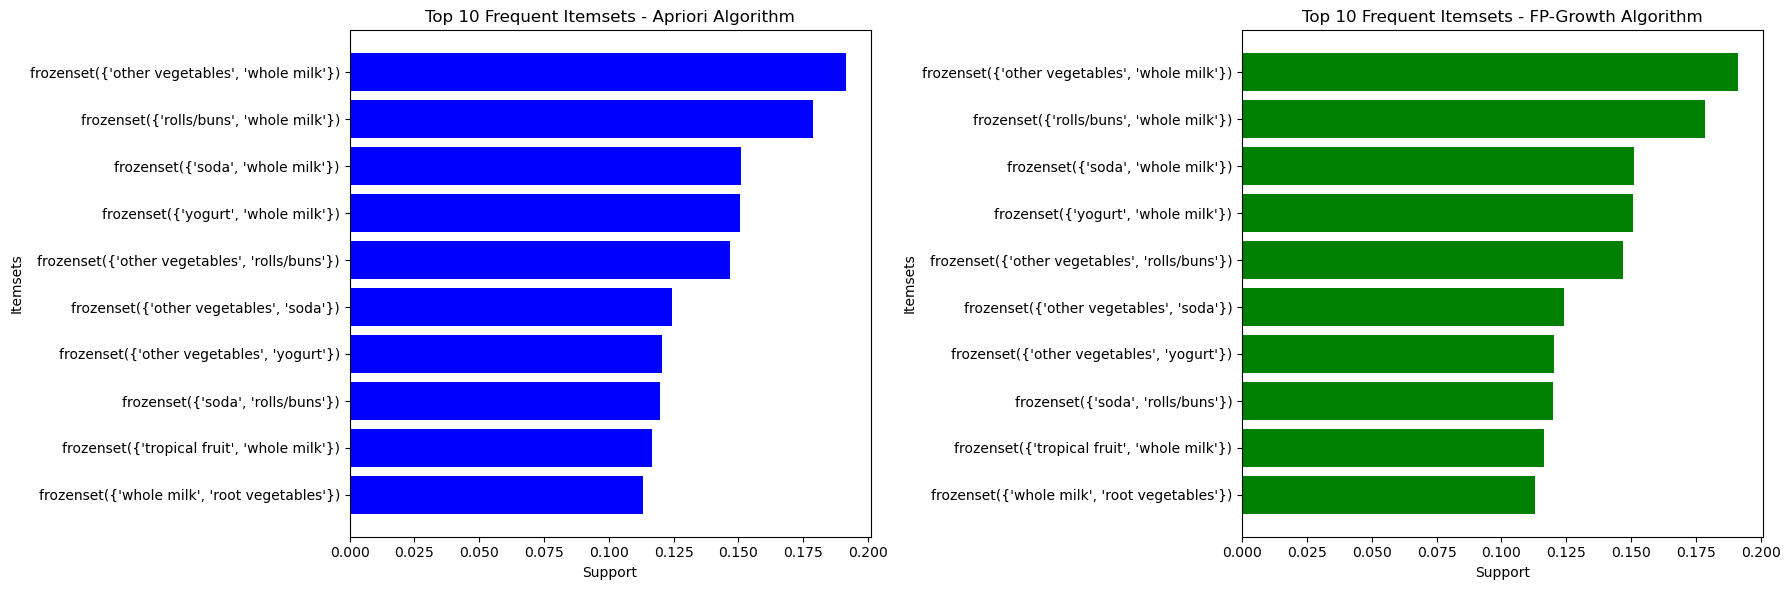

In [30]:
# Side-by-side bar chart for Apriori vs FP-Growth top itemsets
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Apriori results
axes[0].barh([str(item) for item in apriori_results_sorted['itemsets']], apriori_results_sorted['support'], color='blue')
axes[0].set_xlabel('Support')
axes[0].set_ylabel('Itemsets')
axes[0].set_title('Top 10 Frequent Itemsets - Apriori Algorithm')
axes[0].invert_yaxis()

# FP-Growth results
axes[1].barh([str(item) for item in fpgrowth_results_sorted['itemsets']], fpgrowth_results_sorted['support'], color='green')
axes[1].set_xlabel('Support')
axes[1].set_ylabel('Itemsets')
axes[1].set_title('Top 10 Frequent Itemsets - FP-Growth Algorithm')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()